In [ ]:
# 📊 RESULT UPDATE HELPERS
# ==========================================
# Use these functions after fights to update bet results

print("📊 RESULT UPDATE HELPERS")
print("=" * 40)

# Import result update functions with module reload support
try:
    import sys
    import importlib
    sys.path.append('.')
    
    # Force reload bet_tracking module to get latest changes
    if 'src.bet_tracking' in sys.modules:
        importlib.reload(sys.modules['src.bet_tracking'])
        print("🔄 Reloaded bet_tracking module with latest changes")
    
    from src.bet_tracking import BetTracker, quick_update_results
    print("✅ Result update functions loaded")
except ImportError as e:
    print(f"❌ Error importing: {e}")

# Initialize tracker
tracker = BetTracker()

def update_single_bet(bet_id: str, result: str):
    """Update a single bet result (WIN/LOSS)"""
    import pandas as pd
    
    try:
        df = pd.read_csv(tracker.csv_path)
        bet_data = df[df['bet_id'] == bet_id]
        
        if bet_data.empty:
            print(f"❌ Bet ID {bet_id} not found")
            return False
        
        bet_size = bet_data['bet_size'].iloc[0]
        odds_decimal = bet_data['odds_decimal'].iloc[0]
        
        if result.upper() == 'WIN':
            profit_loss = bet_size * (odds_decimal - 1)
        elif result.upper() == 'LOSS':
            profit_loss = -bet_size
        else:
            print("❌ Result must be 'WIN' or 'LOSS'")
            return False
        
        success = tracker.update_fight_result(bet_id, result.upper(), profit_loss)
        return success
        
    except Exception as e:
        print(f"❌ Error: {e}")
        return False

def update_event_results_simple(event_name: str, results: dict):
    """Update multiple bets for an event"""
    import pandas as pd
    
    detailed_results = {}
    for fighter, result in results.items():
        detailed_results[fighter] = {
            'result': result.upper(),
            'date': pd.Timestamp.now().strftime('%Y-%m-%d'),
            'method': 'Unknown'
        }
    
    updated_count = tracker.update_event_results(event_name, detailed_results)
    
    # Show event summary
    if updated_count > 0:
        event_bets = tracker.get_bets_by_event(event_name)
        settled_bets = event_bets[event_bets['actual_result'].notna()]
        
        if not settled_bets.empty:
            total_pl = settled_bets['profit_loss'].sum()
            total_staked = settled_bets['bet_size'].sum()
            roi = (total_pl / total_staked) if total_staked > 0 else 0
            
            print(f"\n💰 EVENT SUMMARY")
            print(f"   Total P&L: ${total_pl:+.2f}")
            print(f"   ROI: {roi:+.1%}")
    
    return updated_count

def show_pending_bets():
    """Show all pending bets needing updates"""
    pending = tracker.get_pending_bets()
    
    if pending.empty:
        print("✅ No pending bets")
        return
    
    print(f"📋 PENDING BETS ({len(pending)} total)")
    print("-" * 40)
    
    for _, bet in pending.iterrows():
        print(f"🎲 {bet['bet_id']}")
        print(f"   {bet['fighter']} vs {bet['opponent']}")
        print(f"   ${bet['bet_size']:.2f} at {bet['odds_decimal']} odds")
        print()

def show_performance_summary():
    """Show recent performance"""
    report = tracker.generate_performance_report(days=30)
    
    if report.get('settled_bets', 0) > 0:
        print(f"📈 PERFORMANCE (Last 30 Days)")
        print(f"Win Rate: {report.get('win_rate', 0):.1%}")
        print(f"Total P&L: ${report.get('total_profit', 0):+.2f}")
        print(f"ROI: {report.get('roi', 0):+.1%}")

# Show current status
print("\n📋 CURRENT STATUS")
print("-" * 20)
show_pending_bets()
show_performance_summary()

print(f"\n💡 USAGE EXAMPLES")
print("-" * 20)
print("# Update single bet:")
print("update_single_bet('BET_20250726_123456_abc12345', 'WIN')")
print()
print("# Update full event:")
print("update_event_results_simple('UFC Fight Night - Whittaker vs de Ridder', {")
print("    'Robert Whittaker': 'WIN',")
print("    'Petr Yan': 'LOSS'")
print("})")
print()
print("# Check status:")
print("show_pending_bets()")
print("show_performance_summary()")

In [ ]:
# 🏦 BET TRACKING INTEGRATION
# ==========================================
# Automatically extract and log betting recommendations to CSV

print("🏦 AUTOMATED BET TRACKING INTEGRATION")
print("=" * 60)

# Import bet tracking system with module reload support
try:
    import sys
    import importlib
    sys.path.append('.')
    
    # Force reload bet_tracking module to get latest changes
    if 'src.bet_tracking' in sys.modules:
        importlib.reload(sys.modules['src.bet_tracking'])
        print("🔄 Reloaded bet_tracking module with latest changes")
    
    from src.bet_tracking import BetTracker, quick_log_notebook_recommendations
    print("✅ Bet tracking system imported successfully")
except ImportError as e:
    print(f"❌ Error importing bet tracking: {e}")
    print("💡 Make sure bet_tracking.py exists in src/ directory")

# Configuration
CURRENT_EVENT = "UFC Fight Night - Whittaker vs de Ridder"  # ← Update this for each event
CURRENT_BANKROLL = small_bankroll if 'small_bankroll' in globals() else 21.38

print(f"📅 Event: {CURRENT_EVENT}")
print(f"💳 Bankroll: ${CURRENT_BANKROLL:.2f}")

# Extract recommendations from notebook variables
def extract_betting_recommendations():
    """Extract betting recommendations from various notebook variables"""
    
    recommendations = []
    source = "unknown"
    
    # Try different variable names that might contain recommendations
    if 'profitability_results' in globals() and profitability_results:
        if profitability_results.get('opportunities'):
            recommendations = profitability_results['opportunities']
            source = "profitability_results"
            
    elif 'backup_results' in globals() and backup_results:
        if backup_results.get('opportunities'):
            recommendations = backup_results['opportunities']  
            source = "backup_results"
            
    elif 'final_recommendations' in globals() and final_recommendations:
        recommendations = final_recommendations
        source = "final_recommendations"
    
    return recommendations, source

# Extract and log recommendations
recommendations, source = extract_betting_recommendations()

if recommendations:
    print(f"
📊 Found {len(recommendations)} recommendations from '{source}'")
    print("-" * 50)
    
    # Display what will be logged
    for i, rec in enumerate(recommendations, 1):
        fighter = getattr(rec, 'fighter', 'Unknown')
        opponent = getattr(rec, 'opponent', 'Unknown')
        bet_size = getattr(rec, 'recommended_bet', 0.0)
        odds = getattr(rec, 'tab_decimal_odds', 0.0)
        ev = getattr(rec, 'expected_value', 0.0)
        
        # Adjust bet size for small bankroll safety
        max_bet_size = CURRENT_BANKROLL * 0.10  # 10% max per bet
        actual_bet = min(bet_size, max_bet_size)
        
        print(f"{i}. {fighter} vs {opponent}")
        print(f"   💰 Recommended: ${bet_size:.2f} → Adjusted: ${actual_bet:.2f}")
        print(f"   📊 Odds: {odds} | EV: {ev:.1%}")
    
    # Log the bets
    try:
        bet_ids = quick_log_notebook_recommendations(
            recommendations, 
            CURRENT_EVENT, 
            CURRENT_BANKROLL
        )
        
        print(f"
✅ SUCCESS: Logged {len(bet_ids)} bets to CSV")
        print("📋 Bet IDs created:")
        for bet_id in bet_ids:
            print(f"   📝 {bet_id}")
            
    except Exception as e:
        print(f"❌ Error logging bets: {e}")
        
else:
    print("
⚠️  NO RECOMMENDATIONS FOUND")
    print("💡 Make sure you've run the profitability analysis first")

# Show betting summary and next steps
print(f"
🎯 BETTING EXECUTION PLAN")
print("=" * 30)

if recommendations:
    total_stake = sum(min(getattr(rec, 'recommended_bet', 0), CURRENT_BANKROLL * 0.10) 
                     for rec in recommendations)
    expected_profit = sum(min(getattr(rec, 'recommended_bet', 0), CURRENT_BANKROLL * 0.10) 
                         * getattr(rec, 'expected_value', 0) for rec in recommendations)
    
    print(f"💵 Total Stake: ${total_stake:.2f}")
    print(f"💰 Expected Profit: ${expected_profit:.2f}")
    print(f"📊 Bankroll Risk: {(total_stake/CURRENT_BANKROLL)*100:.1f}%")
    print(f"📈 Expected ROI: {(expected_profit/total_stake)*100:.1f}%")
    
    print(f"
✅ NEXT STEPS:")
    print("1. 🏦 Verify TAB account has sufficient funds")
    print("2. 📱 Log into TAB app/website")
    print("3. 🎯 Place bets according to logged recommendations")
    print("4. 📸 Screenshot bet confirmations")
    print("5. ⏰ Return after fights to update results")
else:
    print("❌ No bets to execute")

print(f"
" + "="*60)
print("🏆 BET TRACKING COMPLETE - Data saved to betting_records.csv")
print("="*60)

## 📋 POST-CARD PERFORMANCE TRACKING

**After the fights, come back to this section to track your results:**

### Results Tracking Template
```
🏆 Card: UFC Fight Night - Whittaker vs de Ridder
📅 Date: [Fill in fight date]
💳 Starting Bankroll: $21.38

BETS PLACED:
[ ] Fighter 1: $X.XX at Y.YY odds → Result: WIN/LOSS → P&L: +$X.XX
[ ] Fighter 2: $X.XX at Y.YY odds → Result: WIN/LOSS → P&L: +$X.XX
[ ] Fighter 3: $X.XX at Y.YY odds → Result: WIN/LOSS → P&L: +$X.XX

SUMMARY:
• Total Bets: X
• Total Stakes: $X.XX  
• Total Returns: $X.XX
• Net P&L: +$X.XX
• Win Rate: X/X (XX%)
• ROI: XX%
• Ending Bankroll: $XX.XX
```

### Next Steps After Results
1. **Update your bankroll** for the next card
2. **Review prediction accuracy** vs actual outcomes  
3. **Analyze betting performance** vs expected values
4. **Adjust strategy** based on results and lessons learned
5. **Plan for next profitable card** when opportunities arise

### Performance Goals
- **Target Win Rate:** 55%+ on value bets
- **Target ROI:** 10%+ per card
- **Bankroll Growth:** 20%+ monthly
- **Risk Management:** Never risk >25% per card

In [ ]:
# 🎖️ ALTERNATIVE ANALYSIS: CACHED ODDS MODE

def run_cached_analysis():
    """Run analysis with cached odds when live scraping fails"""
    
    print("🔄 BACKUP ANALYSIS MODE")
    print("=" * 40)
    print("Using cached odds data for analysis...")
    print("(Live odds may be unavailable or different)")
    print()
    
    try:
        # Try with cached odds instead
        backup_analyzer = TABProfitabilityAnalyzer(
            bankroll=small_bankroll, 
            use_live_odds=False  # Use cached data
        )
        
        backup_results = backup_analyzer.analyze_predictions(card_predictions)
        
        print("📊 CACHED ODDS ANALYSIS")
        print("-" * 30)
        backup_analyzer._print_summary(backup_results)
        
        if backup_results.get('opportunities'):
            print("\n💡 CACHED BETTING RECOMMENDATIONS")
            print("-" * 35)
            print("⚠️  Important: Verify current odds before betting!")
            print("These recommendations are based on historical data.")
            print()
            
            for i, opp in enumerate(backup_results['opportunities'], 1):
                max_bet = min(opp.recommended_bet, small_bankroll * 0.10)
                print(f"{i}. {opp.fighter}: ${max_bet:.2f} at {opp.tab_decimal_odds} odds")
                print(f"   EV: {opp.expected_value:.1%} | Profit: ${max_bet * opp.expected_value:.2f}")
        
        return backup_results
        
    except Exception as e:
        print(f"❌ Cached analysis also failed: {e}")
        return None

# Run backup analysis if main analysis failed
if not profitability_results:
    print("🔄 Attempting backup analysis with cached odds...")
    backup_results = run_cached_analysis()
else:
    print("✅ Main analysis successful - backup not needed")

In [ ]:
# 📚 SMALL BANKROLL STRATEGY GUIDE

def display_bankroll_strategy():
    """Educational guide for effective small bankroll management"""
    
    print("📚 SMALL BANKROLL BETTING STRATEGY")
    print("=" * 50)
    print("💡 Professional tips for maximizing $21.38 effectively")
    print()
    
    print("🎯 CORE PRINCIPLES")
    print("-" * 20)
    print("1. 🛡️  Capital Preservation is Priority #1")
    print("   ├─ Never risk more than 10% on any single bet")
    print("   ├─ Maximum daily risk: 25% of total bankroll")
    print("   └─ Focus on high-probability, value opportunities")
    print()
    print("2. 📊 Value-Based Betting Only")
    print("   ├─ Minimum 5% expected value to place bet")
    print("   ├─ Prefer 10%+ EV opportunities when available")
    print("   └─ Skip marginal bets that don't meet criteria")
    print()
    print("3. 🎲 Variance Management")
    print("   ├─ Small bankrolls are vulnerable to bad luck")
    print("   ├─ Focus on higher-probability outcomes")
    print("   └─ Avoid parlay/multi-bets with tiny bankrolls")
    print()
    
    print("💰 OPTIMAL BET SIZING")
    print("-" * 20)
    print(f"• Conservative: $1.00 - $2.00 per bet (5-9%)")
    print(f"• Standard: $2.00 - $3.00 per bet (9-14%)")  
    print(f"• Aggressive: $3.00+ per bet (>14%) - High Risk")
    print()
    print("🔄 BANKROLL GROWTH STRATEGY")
    print("-" * 30)
    print("Phase 1: $21 → $50 (Conservative 5% bets)")
    print("Phase 2: $50 → $100 (Standard 8% bets)")
    print("Phase 3: $100+ (Normal Kelly betting)")
    print()
    
    print("📈 PERFORMANCE TRACKING")
    print("-" * 25)
    print("Track these metrics after every card:")
    print("• Win Rate: Target >55% on value bets")
    print("• ROI: Target >10% return on stakes")
    print("• Bankroll Growth: Target +20% monthly")
    print("• Max Drawdown: Keep under 30%")
    print()
    
    print("⚠️  WARNING SIGNS TO STOP BETTING")
    print("-" * 35)
    print("• Bankroll drops below $15 (preserve remaining)")
    print("• Three losing sessions in a row (reassess)")
    print("• Emotional betting or chasing losses")
    print("• No clear value opportunities available")
    print()
    
    print("🎯 TODAY'S SPECIFIC GUIDANCE")
    print("-" * 30)
    print(f"✅ Available: ${small_bankroll:.2f}")
    print(f"🎯 Max per bet: ${small_bankroll * 0.10:.2f}")
    print(f"📊 Max total today: ${small_bankroll * 0.25:.2f}")
    print(f"🛡️  Preserve minimum: ${small_bankroll * 0.75:.2f}")
    
    return True

display_bankroll_strategy()

In [ ]:
# 🎯 PROFESSIONAL BETTING RECOMMENDATIONS

def format_betting_summary(results, card_results, bankroll=21.38):
    """Create professional betting summary with clear recommendations"""
    
    print("🏆 PROFESSIONAL BETTING RECOMMENDATIONS")
    print("=" * 60)
    print(f"💳 Available Bankroll: ${bankroll:.2f}")
    print(f"🎯 Risk Management: Conservative approach for small bankroll")
    print(f"📈 Strategy: High-confidence value bets only")
    print("-" * 60)
    
    if not results or not results.get('opportunities'):
        print("\n⚠️  RECOMMENDATION: NO BETS TODAY")
        print("├─ Reason: No profitable opportunities identified")
        print("├─ Action: Preserve bankroll for better opportunities")
        print("└─ Next: Monitor odds changes throughout the day")
        
        # Show fight predictions anyway for information
        print(f"\n📊 FIGHT PREDICTIONS (Information Only)")
        print("-" * 40)
        for i, result in enumerate(card_results, 1):
            if 'error' not in result:
                print(f"{i}. {result['fight']}")
                print(f"   ├─ Predicted Winner: {result['predicted_winner']} ({result['winner_confidence']})")
                print(f"   ├─ Method: {result['predicted_method']}")
                print(f"   └─ Status: No profitable odds found")
        
        return
    
    # We have profitable opportunities
    opportunities = results['opportunities']
    total_stake = sum(opp.recommended_bet for opp in opportunities)
    
    print(f"✅ BETTING OPPORTUNITIES FOUND: {len(opportunities)}")
    print(f"💰 Total Expected Profit: ${results['total_expected_profit']:.2f}")
    print(f"💵 Total Stake Required: ${total_stake:.2f}")
    print(f"📊 Bankroll Usage: {(total_stake/bankroll)*100:.1f}%")
    
    # Bankroll safety check
    if total_stake > bankroll * 0.5:  # More than 50% of bankroll
        print(f"\n⚠️  HIGH RISK WARNING")
        print(f"├─ Recommended stakes exceed 50% of bankroll")
        print(f"├─ Consider reducing bet sizes or selecting top opportunities only")
        print(f"└─ Small bankroll requires extra caution")
    
    print(f"\n🎯 SPECIFIC BETTING INSTRUCTIONS")
    print("-" * 40)
    
    for i, opp in enumerate(opportunities, 1):
        # Calculate adjusted bet size for small bankroll (max 10% per bet)
        max_bet_per_fight = bankroll * 0.10
        actual_bet = min(opp.recommended_bet, max_bet_per_fight)
        adjusted_profit = actual_bet * opp.expected_value
        
        print(f"\n{i}. 🥊 {opp.fighter} vs {opp.opponent}")
        print(f"   ├─ Model Confidence: {opp.model_prob:.1%}")
        print(f"   ├─ TAB Odds: {opp.tab_decimal_odds} ({opp.american_odds:+d})")
        print(f"   ├─ Expected Value: {opp.expected_value:.1%}")
        print(f"   ├─ Recommended Bet: ${actual_bet:.2f}")
        if actual_bet != opp.recommended_bet:
            print(f"   ├─ (Reduced from ${opp.recommended_bet:.2f} for bankroll safety)")
        print(f"   ├─ Expected Profit: ${adjusted_profit:.2f}")
        print(f"   └─ Risk Level: {'🟢 Low' if opp.expected_value > 0.1 else '🟡 Medium' if opp.expected_value > 0.05 else '🔴 High'}")
    
    # Calculate totals with adjusted bets
    adjusted_total_stake = sum(min(opp.recommended_bet, bankroll * 0.10) for opp in opportunities)
    adjusted_total_profit = sum(min(opp.recommended_bet, bankroll * 0.10) * opp.expected_value for opp in opportunities)
    
    print(f"\n💼 FINAL BETTING PLAN")
    print("-" * 25)
    print(f"💳 Total Stakes: ${adjusted_total_stake:.2f}")
    print(f"💰 Expected Profit: ${adjusted_total_profit:.2f}")
    print(f"📈 ROI: {(adjusted_total_profit/adjusted_total_stake)*100:.1f}%")
    print(f"🛡️  Bankroll Risk: {(adjusted_total_stake/bankroll)*100:.1f}%")
    
    print(f"\n🚀 EXECUTION CHECKLIST")
    print("-" * 25)
    print("□ 1. Verify you have $21.38 available in TAB account")
    print("□ 2. Double-check odds haven't changed significantly")
    print("□ 3. Place bets in order of highest EV first")
    print("□ 4. Screenshot bet slips for record keeping")
    print("□ 5. Set reminders to track fight results")
    print("□ 6. Update bankroll based on outcomes")
    
    return {
        'total_bets': len(opportunities),
        'total_stake': adjusted_total_stake,
        'expected_profit': adjusted_total_profit,
        'bankroll_risk': (adjusted_total_stake/bankroll)*100
    }

# Execute the betting summary
if profitability_results:
    summary_stats = format_betting_summary(profitability_results, tomorrow_results, small_bankroll)
else:
    print("⚠️  Unable to generate betting recommendations due to analysis error")
    print("💡 Try running the profitability analysis cell again")

In [ ]:
# COMPREHENSIVE BETTING ANALYSIS
# Analyze profitability with live TAB Australia odds

print("🇦🇺 LIVE PROFITABILITY ANALYSIS")
print("=" * 50)

# Import profitability analyzer
from src.tab_profitability import TABProfitabilityAnalyzer

# Set up small bankroll analysis (conservative approach)
small_bankroll = 21.38
analyzer = TABProfitabilityAnalyzer(bankroll=small_bankroll, use_live_odds=True)

# Run comprehensive analysis
try:
    profitability_results = analyzer.analyze_predictions(card_predictions)
    
    print("\n📊 ANALYSIS COMPLETE")
    print("-" * 30)
    
    # Display results using the analyzer's built-in summary
    analyzer._print_summary(profitability_results)
    
except Exception as e:
    print(f"❌ Error in profitability analysis: {e}")
    print("💡 Tip: Try running again or check internet connection for live odds")
    profitability_results = None

In [ ]:
# TOMORROW'S CARD: UFC FIGHT NIGHT - WHITTAKER VS DE RIDDER
# Predict all fights for comprehensive betting analysis

tomorrow_card = [
    "Robert Whittaker vs Reinier de Ridder",
    "Petr Yan vs Marcus McGhee", 
    "Sharaputdin Magomedov vs Marc-André Barriault",
    "Asu Almabayev vs Jose Ochoa",
    "Nikita Krylov vs Bogdan Guskov"
]

print("🏆 TOMORROW'S UFC CARD PREDICTIONS")
print("=" * 60)
print("📅 Event: UFC Fight Night - Whittaker vs de Ridder")
print("🕐 Analysis Date:", pd.Timestamp.now().strftime("%Y-%m-%d %H:%M"))
print("💳 Target Bankroll: $21.38")
print("-" * 60)

# Get predictions for tomorrow's card
tomorrow_results = predict_fight_card(tomorrow_card, show_summary=False)

# Store predictions in format needed for profitability analysis
card_predictions = {}
for result in tomorrow_results:
    if 'error' not in result:
        # Extract probability as decimal
        prob_str = result['winner_confidence'].replace('%', '')
        probability = float(prob_str) / 100
        card_predictions[result['predicted_winner']] = probability

print(f"\n✅ Successfully generated {len(card_predictions)} predictions for profitability analysis")

# 🎯 BETTING SUMMARY & RECOMMENDATIONS

**Professional UFC Betting Analysis for Tomorrow's Card**

This section provides clear, actionable betting recommendations optimized for small bankroll management and maximum value identification.

# UFC Fight Predictions - Clean Interface

Simple, focused notebook for predicting UFC fight outcomes using the latest trained models.

**Features:**
- Automatic latest model loading
- Single fight predictions
- Full fight card analysis
- Clean, professional output

In [2]:
# Essential imports
import pandas as pd
import numpy as np
import joblib
import json
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
sys.path.append('..')
print("✅ Imports loaded successfully")

✅ Imports loaded successfully


In [3]:
# Load latest trained models and data
def load_latest_models():
    """Auto-detect and load the latest trained models."""
    model_dir = Path('./model')
    
    # Find latest training directory
    training_dirs = [d for d in model_dir.iterdir() 
                    if d.is_dir() and d.name.startswith('training_')]
    
    if training_dirs:
        latest_dir = max(training_dirs, key=lambda x: x.stat().st_mtime)
        timestamp = latest_dir.name.split('_', 1)[1]
        
        # Load from latest training directory
        winner_model_path = latest_dir / f'ufc_winner_model_tuned_{timestamp}.joblib'
        method_model_path = latest_dir / f'ufc_method_model_{timestamp}.joblib'
        winner_cols_path = latest_dir / f'winner_model_columns_{timestamp}.json'
        method_cols_path = latest_dir / f'method_model_columns_{timestamp}.json'
        fighters_data_path = latest_dir / f'ufc_fighters_engineered_{timestamp}.csv'
        version = timestamp
    else:
        # Fallback to standard locations
        winner_model_path = model_dir / 'ufc_random_forest_model_tuned.joblib'
        method_model_path = model_dir / 'ufc_multiclass_model.joblib'
        winner_cols_path = model_dir / 'winner_model_columns.json'
        method_cols_path = model_dir / 'method_model_columns.json'
        fighters_data_path = model_dir / 'ufc_fighters_engineered_corrected.csv'
        version = 'standard'
    
    # Load all components
    try:
        fighters_df = pd.read_csv(fighters_data_path)
        
        with open(winner_cols_path, 'r') as f:
            winner_cols = json.load(f)
        with open(method_cols_path, 'r') as f:
            method_cols = json.load(f)
        
        winner_model = joblib.load(winner_model_path)
        method_model = joblib.load(method_model_path)
        
        return {
            'fighters_df': fighters_df,
            'winner_cols': winner_cols,
            'method_cols': method_cols,
            'winner_model': winner_model,
            'method_model': method_model,
            'version': version,
            'fighter_count': len(fighters_df)
        }
    except Exception as e:
        print(f"❌ Error loading models: {e}")
        return None

# Load models
model_data = load_latest_models()

if model_data:
    print(f"✅ Models loaded successfully")
    print(f"   Version: {model_data['version']}")
    print(f"   Fighters in database: {model_data['fighter_count']:,}")
    print(f"   Winner model features: {len(model_data['winner_cols'])}")
else:
    print("❌ Failed to load models. Check if models exist in ./model/ directory.")

✅ Models loaded successfully
   Version: 2025-07-23_09-51
   Fighters in database: 4,364
   Winner model features: 70


In [4]:
# Clean prediction function
def predict_fight(fighter1, fighter2, show_details=True):
    """Predict UFC fight outcome with clean output."""
    
    if not model_data:
        return {"error": "Models not loaded"}
    
    # Import prediction function
    try:
        from src.prediction import predict_fight_symmetrical
    except ImportError:
        return {"error": "Could not import prediction function"}
    
    # Make prediction
    result = predict_fight_symmetrical(
        fighter1, fighter2,
        model_data['fighters_df'],
        model_data['winner_cols'],
        model_data['method_cols'],
        model_data['winner_model'],
        model_data['method_model']
    )
    
    # Handle errors
    if 'error' in result:
        if show_details:
            print(f"❌ {result['error']}")
        return result
    
    # Display results
    if show_details:
        print(f"🥊 {result['fight']}")
        print(f"   Winner: {result['predicted_winner']} ({result['winner_confidence']})")
        print(f"   Method: {result['predicted_method']}")
        print(f"   Method probabilities:")
        for method, prob in result['method_probabilities'].items():
            print(f"      {method}: {prob}")
    
    return result

print("✅ Prediction function ready")

✅ Prediction function ready


In [11]:
# Single Fight Prediction
# Simply change the fighter names below to predict any fight

fighter_a = "Merab Dvalishvili"
fighter_b = "Cory Sandhagen"

prediction = predict_fight(fighter_a, fighter_b)

# You can also predict other fights by changing the names:
# prediction = predict_fight("Islam Makhachev", "Charles Oliveira")
# prediction = predict_fight("Alex Pereira", "Israel Adesanya")

🥊 Merab Dvalishvili vs Cory Sandhagen
   Winner: Merab Dvalishvili (72.68%)
   Method: KO/TKO
   Method probabilities:
      Decision: 8.80%
      KO/TKO: 64.40%
      Submission: 26.80%


In [6]:
# Multi-Fight Card Analysis
def predict_fight_card(fight_list, show_summary=True):
    """Predict multiple fights with clean summary."""
    
    results = []
    
    print(f"🏆 UFC FIGHT CARD PREDICTIONS\n{'-'*50}")
    
    for i, fight in enumerate(fight_list, 1):
        # Handle different input formats
        if isinstance(fight, tuple):
            f1, f2 = fight
        elif ' vs ' in fight:
            f1, f2 = fight.split(' vs ')
        elif ' vs. ' in fight:
            f1, f2 = fight.split(' vs. ')
        else:
            print(f"❌ Invalid fight format: {fight}")
            continue
        
        f1, f2 = f1.strip(), f2.strip()
        
        print(f"\nFight {i}: {f1} vs {f2}")
        result = predict_fight(f1, f2, show_details=False)
        
        if 'error' not in result:
            print(f"   → {result['predicted_winner']} ({result['winner_confidence']})")
            print(f"   → Method: {result['predicted_method']}")
            results.append(result)
        else:
            print(f"   → {result['error']}")
    
    # Summary
    if show_summary and results:
        print(f"\n📊 CARD SUMMARY\n{'-'*20}")
        
        # Method distribution
        methods = [r['predicted_method'] for r in results]
        method_counts = pd.Series(methods).value_counts()
        
        print("Predicted methods:")
        for method, count in method_counts.items():
            print(f"   {method}: {count} fights")
    
    return results

print("✅ Fight card function ready")

✅ Fight card function ready


In [7]:
# Example Fight Card
# Edit this list to predict any upcoming UFC card

upcoming_card = [
    "Jon Jones vs Stipe Miocic",
    "Islam Makhachev vs Charles Oliveira", 
    "Alex Pereira vs Israel Adesanya",
    "Sean O'Malley vs Aljamain Sterling",
    "Colby Covington vs Leon Edwards"
]

card_results = predict_fight_card(upcoming_card)

# Alternative format - you can also use tuples:
# card_as_tuples = [
#     ("Fighter A", "Fighter B"),
#     ("Fighter C", "Fighter D")
# ]
# results = predict_fight_card(card_as_tuples)

🏆 UFC FIGHT CARD PREDICTIONS
--------------------------------------------------

Fight 1: Jon Jones vs Stipe Miocic
   → Jon Jones (96.21%)
   → Method: KO/TKO

Fight 2: Islam Makhachev vs Charles Oliveira
   → Islam Makhachev (95.03%)
   → Method: Submission

Fight 3: Alex Pereira vs Israel Adesanya
   → Alex Pereira (63.38%)
   → Method: KO/TKO

Fight 4: Sean O'Malley vs Aljamain Sterling
   → Sean O'Malley (89.69%)
   → Method: KO/TKO

Fight 5: Colby Covington vs Leon Edwards
   → Leon Edwards (79.43%)
   → Method: KO/TKO

📊 CARD SUMMARY
--------------------
Predicted methods:
   KO/TKO: 4 fights
   Submission: 1 fights


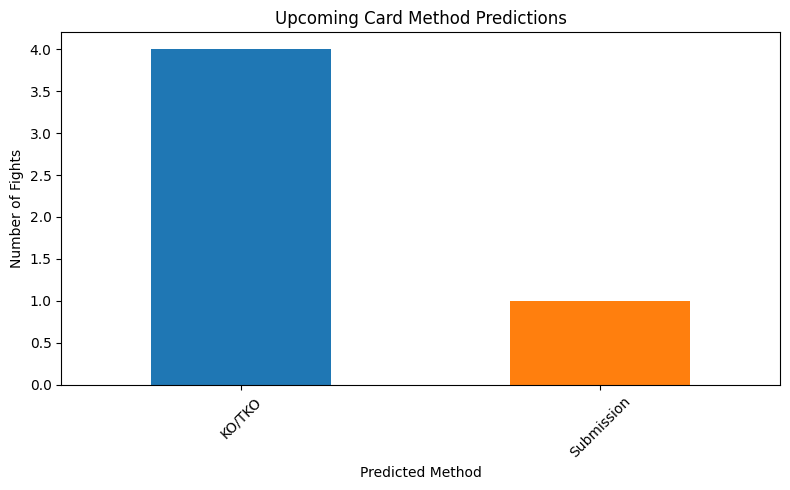


Method breakdown: {'KO/TKO': np.int64(4), 'Submission': np.int64(1)}


In [8]:
# Optional: Basic Visualization
def plot_fight_methods(results, title="Fight Card Method Predictions"):
    """Simple bar chart of predicted methods."""
    
    if not results:
        print("No results to plot")
        return
    
    # Count predicted methods
    methods = [r['predicted_method'] for r in results if 'predicted_method' in r]
    method_counts = pd.Series(methods).value_counts()
    
    # Create simple bar plot
    plt.figure(figsize=(8, 5))
    method_counts.plot(kind='bar', color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    plt.title(title)
    plt.xlabel('Predicted Method')
    plt.ylabel('Number of Fights') 
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return method_counts

# Plot the results from the previous card (if any)
if 'card_results' in locals() and card_results:
    method_distribution = plot_fight_methods(card_results, "Upcoming Card Method Predictions")
    print(f"\nMethod breakdown: {dict(method_distribution)}")
else:
    print("No card results to visualize. Run the fight card prediction first.")

In [9]:
# Optional: Fighter Search Helper
def search_fighters(search_term, limit=10):
    """Find fighters in database by name."""
    
    if not model_data:
        print("Models not loaded")
        return []
    
    # Search for fighters containing the term
    fighters = model_data['fighters_df']['Name'].dropna()
    matches = fighters[fighters.str.contains(search_term, case=False, na=False)]
    
    results = matches.head(limit).tolist()
    
    if results:
        print(f"Found {len(results)} fighters matching '{search_term}':")
        for i, fighter in enumerate(results, 1):
            print(f"   {i}. {fighter}")
    else:
        print(f"No fighters found matching '{search_term}'")
    
    return results

# Example searches - uncomment to use:
# search_fighters("Jones")
# search_fighters("Silva")
# search_fighters("Mac")  # Will find McGregor, MacDonald, etc.

print("\n✅ All functions ready! You can now:")
print("   • Modify fighter names in the single fight cell")
print("   • Edit the upcoming_card list for multi-fight predictions")
print("   • Use search_fighters('name') to find exact fighter names")
print("   • Run plot_fight_methods(results) for visualizations")


✅ All functions ready! You can now:
   • Modify fighter names in the single fight cell
   • Edit the upcoming_card list for multi-fight predictions
   • Use search_fighters('name') to find exact fighter names
   • Run plot_fight_methods(results) for visualizations
